In [41]:
import re
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from wordcloud import WordCloud, STOPWORDS
from geopy.extra.rate_limiter import RateLimiter

import ipywidgets as widgets
from ipywidgets import Layout

In [42]:
data = pd.read_csv("train.csv")

In [43]:
duplicated_data = data['text'].duplicated().sum()

In [44]:
data = data.drop_duplicates(subset=['text'], keep='first')

In [45]:
def clean_data(text):
    text = text.lower()
    text = re.sub(r'http[s]?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = " ".join(text.split())
    return text

In [46]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )

    return emoji_pattern.sub(r'', text)

In [47]:
data['text'] = data['text'].apply(clean_data)

In [48]:
data['text'] = data['text'].apply(remove_emojis)

In [49]:
data['location'] = data['location'].replace({
    "United States": "USA",
    "London, UK": "UK",
    "Atlanta, GA": "Atlanta",
    "New York City": "New York",
    "NYC": "New York",
    "San Francisco, CA": "San Francisco",
    "California, USA": "California",
    "Chicago, IL": "Chicago",
    "Los Angeles, CA": "Los Angeles",
    "New York, NY": "New York",
    "United Kingdom": "UK",
    "London, England": "London",
    "Everywhere": "Worldwide",
    "Earth": "Worldwide",
    "Washington, DC": "Washington",
    "Washington, D.C.": "Washington"
})

<h1 align="center"> Disaster Tweets </h1>
<br>

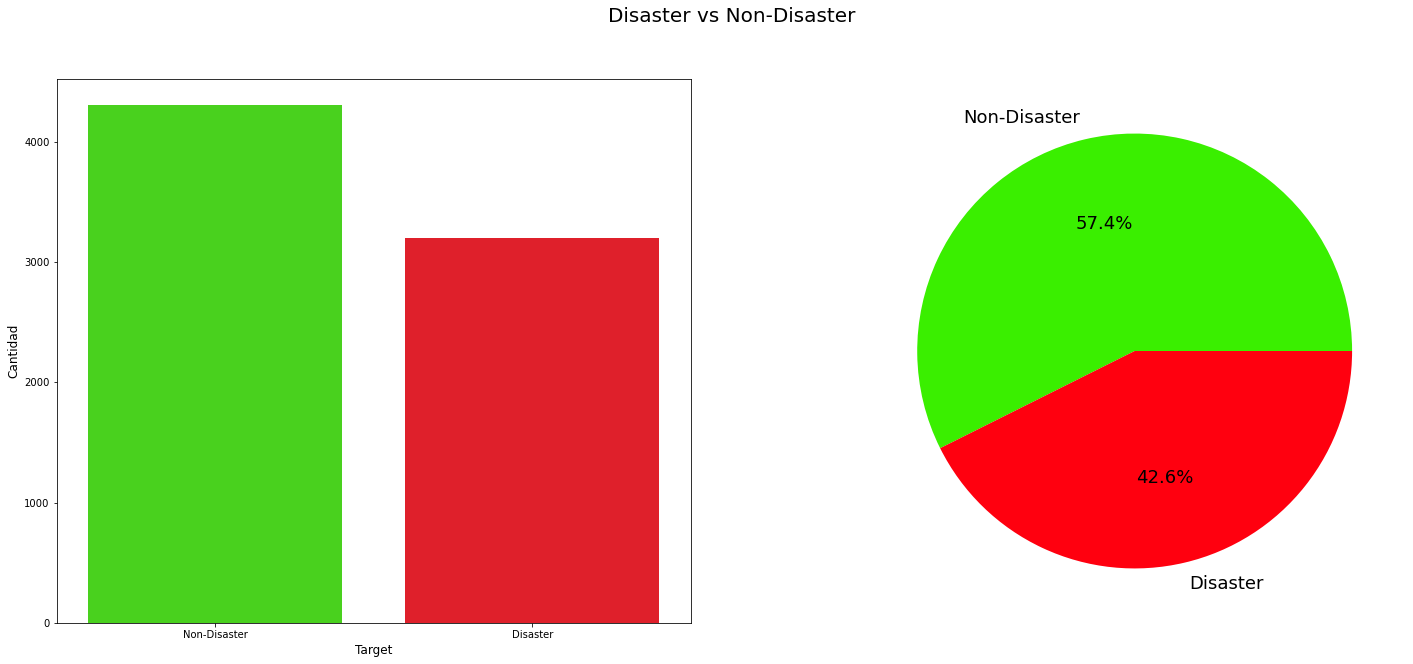

In [60]:
target_values = ['Non-Disaster', 'Disaster']
target = data['target'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(25,10))
fig.suptitle('Disaster vs Non-Disaster', fontsize=20)
colors = sns.color_palette('prism')

sns.barplot(x=target_values, y=target, palette=colors, ax=ax[0])
data.groupby('target').count()['id'].plot(kind='pie', ax=ax[1], labels=target_values, autopct="%.1f%%", colors = colors, fontsize=18)

ax[0].set_xlabel('Target', fontsize=12)
ax[0].set_ylabel('Cantidad', fontsize=12)
ax[1].set_ylabel('')

plt.show()

In [141]:
target1 = data[data['target']==1]['keyword'].value_counts()
target0 = data[data['target']==0]['keyword'].value_counts()
target_data = [value for value in target1.index.tolist() if value in target0.index.tolist()]

unique_keyword = data.keyword.unique()
u = data['keyword'].value_counts().nlargest(10)
keywords = widgets.SelectMultiple(
    options = target_data,
    value = u.index.tolist(),
    description='Keyword',
    disabled = False,
    layout = Layout(width='50%', height='80px', display='flex')
)

In [93]:
location1 = data[data['target']==1]['location'].value_counts()
location0 = data[data['target']==0]['location'].value_counts()
target_data = [value for value in location1.index.tolist() if value in location0.index.tolist()]


unique_location = data.location.unique()
h = data[data['target']==1]['location'].value_counts().nlargest(10)
locations = widgets.SelectMultiple(
    options = target_data,
    value = h.index.tolist(),
    description='Location',
    disabled=False,
    layout = Layout(width='50%', height='80px', display='flex')
)

In [148]:
def disaster_keywords_plot(keywords):
    temp_data = data.loc[data['keyword'].isin(keywords)]
    disaster_keywords = temp_data[temp_data['target']==1]['keyword'].value_counts().nlargest(10)
    non_disaster_keywords = temp_data[temp_data['target']==0]['keyword'].value_counts().nlargest(10)

    fig, ax = plt.subplots(1,2, figsize=(25,10))
    sns.barplot(x=disaster_keywords.tolist(), y=disaster_keywords.index, orient='h', palette=['#ED6A5A'], ax=ax[0])
    sns.barplot(x=non_disaster_keywords.tolist(), y=non_disaster_keywords.index, orient='h', palette=['#55B56A'], ax=ax[1])

    ax[0].set_title('Disaster Keywords\n', fontsize=20)
    ax[0].set_xlabel('Cantidad', fontsize=12)
    ax[0].set_ylabel('Palabra', fontsize=12)

    ax[1].set_title('Non-Disaster Keywords\n', fontsize=20)
    ax[1].set_xlabel('Cantidad', fontsize=12)
    ax[1].set_ylabel('Palabra', fontsize=12)
    plt.show()

In [149]:
widgets.interactive(disaster_keywords_plot, keywords=keywords)

interactive(children=(SelectMultiple(description='Keyword', index=(26, 179, 160, 186, 216, 69, 39, 86, 183, 16…

In [62]:
def disaster_locations_plot(locations):
    temp_data = data.loc[data['location'].isin(locations)]
    disaster_locations = temp_data[temp_data['target']==1]['location'].value_counts().nlargest(10)
    non_disaster_locations = temp_data[temp_data['target']==0]['location'].value_counts().nlargest(10)

    fig, ax = plt.subplots(1,2, figsize=(25,10))
    sns.barplot(x=disaster_locations.tolist(), y=disaster_locations.index, orient='h', palette='Reds_r', ax=ax[0])
    sns.barplot(x=non_disaster_locations.tolist(), y=non_disaster_locations.index, orient='h', palette='Greens_r', ax=ax[1])

    ax[0].set_title('Disaster Locations\n', fontsize=20)
    ax[0].set_xlabel('Cantidad', fontsize=12)
    ax[0].set_ylabel('Palabra', fontsize=12)

    ax[1].set_title('Non-Disaster Locations\n', fontsize=20)
    ax[1].set_xlabel('Cantidad', fontsize=12)
    ax[1].set_ylabel('Palabra', fontsize=12)
    plt.show()

In [55]:
widgets.interactive(disaster_locations_plot, locations=locations)

interactive(children=(SelectMultiple(description='Location', index=(18,), layout=Layout(display='flex', height…

In [56]:
def disaster_map_plot(locations):
    df = data['location'].value_counts()[:20,]
    df = pd.DataFrame(df)
    df = df.reset_index()
    df.columns = ['location', 'counts'] 
    geolocator = Nominatim(user_agent="main")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    dictt_latitude = {}
    dictt_longitude = {}

    for i in df['location'].values:
        location = geocode(i)
        dictt_latitude[i] = location.latitude
        dictt_longitude[i] = location.longitude

    df['latitude']= df['location'].map(dictt_latitude)
    df['longitude'] = df['location'].map(dictt_longitude)

    map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
    markers = []

    for i, row in df.iterrows():
        loss = row['counts']
        if row['counts'] > 0:
            count = row['counts']*0.4
        folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)

    print(map1)

In [57]:
widgets.interactive(disaster_map_plot, locations=locations)


interactive(children=(SelectMultiple(description='Location', index=(18,), layout=Layout(display='flex', height…